<a href="https://colab.research.google.com/github/Nebius-Academy/LLM-Engineering-Essentials/blob/main/topic4/4.3_llm_inference_metrics_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Engineering Essentials by Nebius Academy

Course github: [link](https://github.com/Nebius-Academy/LLM-Engineering-Essentials/tree/main)

The course is in development now, with more materials coming soon.

# 4.3. LLM Inference Metrics - practice solutions

# Practice part

**This part is by [Stanislav Fedotov](https://www.linkedin.com/in/stanislav-fedotov-1651b0243/)**

For most of this notebook, an **L4** or **L40s** will be sufficient. For Task 3, you'll need a GPU that supports FlashAttention2, such as **A100**, **H100**, or **H200**.

## Task 1. GPU and long contexts

So far, we mainly discussed how LLM inference behaves as the batch size increases. However, there is another dimension to it - sequence length. Elaborate prompts, rich context, and, of course, non-linear reasoning contribute to large sequence lengths. And you'd want to know which context size fits your GPU and how latency changes with it!

In this task, we encourage you to experiment with [**Llama-3.1-8B-Instruct**](https://huggingface.co/meta-llama/Llama-3.1-8B). Run inference with

* prompt lengths starting from, say, 512 with step 1024 (if you're generous), 2048, or 4095 (if you're low on time or Colab compute units).
* several values of `max_new_tokens` (completion length), say, 128, 256, and 512.

Make sure that your model *really* produces `max_new_tokens` tokens and not less, otherwise your results will be skewed. You can achieve this by passing `eos_token_id=None` in the generation parameters.

Check at which prompt size the generator pipeline will crash with the out-of-memory error. How closely will you be able to approach the theoretical sequence length 200k? Measure latency and memory consumption and plot curves *prompt length vs latency* and *prompt length vs memory consumption* for each value of `max_new_tokens`. Compare these curves.

**Note**. It would seem more logical to plot *(prompt length + completion length) vs latency* and *(prompt length + completion length) vs memory consumption*, and we recommend you to try it as well. But looking at *prompt length vs ...* might prove instructive.

Also, make theoretical computations and compare them with your empyrical evidence. Ponder on the nature of their differences.

**Note**. For this task, you'll need a way of getting prompts with prescribed length. Here is a couple of ideas where to get them:

* Clone a relatively large code library (`transformers`, for example) and concatenate files until you get the needed prompt size. Then add `"What is the purpose and functionality of this code?"` or something like that. Just don't forget that this question also contributes to the prompt length.
* Pick a long enough book, take its beginning and ask `"Describe the plot and the characters of the above fragment"`

**Note**. We suggest not using `apply_chat_template` and just passing the raw prompts into `pipeline(prompt, return_full_text=False,**generation_params)`. This will make easier for you to control the actual prompt length.

**Note**. If you want your experiments to run faster, use a smaller model, say, **Qwen2.5-3B-Instruct**.

**Solution**

**A theoretical computation**. As we discussed in the long read, LLM inference requires roughly the following amount of memory:

$$M_{\text{parameters}} + \text{batch_size}\cdot\text{KV_cache_size},$$

where $M_{\text{parameters}}$ is the LLM size, which can be inferred from what `nvidia-smi` shows us right after we load the model.

In our case, `batch_size = 1` and the size of the KV cache may be estimated as

$$\text{seq_len}\cdot\text{num_layers}\cdot\text{num_kv_heads} \cdot \text{head_dim} \cdot 2 \cdot 2,$$

where the final $2\times2$ comes from [key + value] and 2 bytes per floating point number.

For Llama-3.1-8B it's

$$\text{seq_len}\cdot 32\cdot 8\cdot 128\cdot 2\cdot 2 = \text{seq_len}\cdot 131072\ \text{bytes}$$

which is roughly $\text{seq_len}\cdot 0.00013$ Gb.

After loading the model, we have $23034\text{MiB} - 15507\text{MiB} \approx 7.5\text{Gb}$.




In [ ]:
32*8*128*2*2

131072

**Experiments**. Let draw some plots for several `max_new_token` options.

Loading the tokenizer and the model:

In [ ]:
import os
import time
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers
from huggingface_hub import snapshot_download

# Setup
os.environ["TOKENIZERS_PARALLELISM"] = "false"

with open("hf_access_token", "r") as file:
    hf_access_token = file.read().strip()

from huggingface_hub import login
login(token=hf_access_token)

def create_pipeline(
    model_name: str = "meta-llama/Meta-Llama-3.1-8B-Instruct",
    cache_dir: str = "/inference_essentials/model/"):

    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        use_fast=False
    )

    # Downloading the model
    snapshot_download(
        repo_id=model_name,
        cache_dir=cache_dir,
        max_workers=15
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        cache_dir=cache_dir,
        local_files_only=True,
        token=hf_access_token,
    )

    pipeline = transformers.pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        model_kwargs={
            "torch_dtype": torch.bfloat16,
            "cache_dir": cache_dir,
        },
        device_map="auto",
        token=hf_access_token,
    )

    pipeline.tokenizer.pad_token_id = pipeline.tokenizer.eos_token_id
    pipeline.model.generation_config.pad_token_id = pipeline.tokenizer.pad_token_id
    pipeline.tokenizer.padding_side = 'left'

    return tokenizer, model, pipeline

We'll use code from `transformers` and the question `"What is the purpose and functionality of this code?"` for our experiments.

In [ ]:
import os
import subprocess
import tempfile
import shutil
from pathlib import Path

def download_transformers_source(cache_path="./transformers_source"):
    """Download transformers library source code (only if not already cached)"""
    if os.path.exists(cache_path):
        print(f"Using cached transformers source at {cache_path}")
        return cache_path

    print(f"Downloading transformers source to {cache_path}...")
    try:
        subprocess.run([
            "git", "clone", "https://github.com/huggingface/transformers.git",
            cache_path
        ], check=True, capture_output=True)
        print(f"Transformers source downloaded to {cache_path}")
        return cache_path
    except subprocess.CalledProcessError as e:
        print(f"Failed to clone transformers repo: {e}")
        return None

def collect_python_files(repo_path):
    """Collect all Python files from the transformers repository"""
    python_files = []
    repo_path = Path(repo_path)

    for py_file in repo_path.rglob("*.py"):
        try:
            with open(py_file, 'r', encoding='utf-8') as f:
                content = f.read()
                if content.strip():  # Skip empty files
                    python_files.append(content)
        except (UnicodeDecodeError, PermissionError):
            # Skip files that can't be read
            continue

    return python_files

def create_context_of_length(python_files, target_tokens, question="What is the purpose and functionality of this code?"):
    """
    Create a context of approximately target_tokens length

    Args:
        python_files (list): List of Python file contents
        target_tokens (int): Target total length in tokens
        question (str): Question to append at the end

    Returns:
        str: Combined prompt with code and question
    """
    # Calculate how many tokens the question takes
    question_suffix = f"\n\n# QUESTION:\n{question}"
    question_tokens = len(tokenizer.encode(question_suffix, add_special_tokens=False))

    # Calculate how many tokens we need for the code content
    code_tokens_needed = target_tokens - question_tokens

    if code_tokens_needed <= 0:
        raise ValueError(f"Target tokens ({target_tokens}) must be larger than question tokens ({question_tokens})")

    combined_code = ""
    current_tokens = 0

    file_idx = 0
    while current_tokens < code_tokens_needed and file_idx < len(python_files):
        # Add file separator
        if combined_code:
            combined_code += "\n\n# === Next File ===\n\n"

        # Add the next file
        combined_code += python_files[file_idx]

        # Count tokens in current combined code
        current_tokens = len(tokenizer.encode(combined_code, add_special_tokens=False))
        file_idx += 1

    # If we went over, trim to exact length by tokenizing and cutting
    if current_tokens > code_tokens_needed:
        # Tokenize the combined code
        tokens = tokenizer.encode(combined_code, add_special_tokens=False)

        # Cut to exact length needed
        trimmed_tokens = tokens[:code_tokens_needed]

        # Decode back to text
        combined_code = tokenizer.decode(trimmed_tokens, skip_special_tokens=True)

    # Combine code with question
    full_prompt = f"{combined_code}{question_suffix}"
    return full_prompt

cache_path = download_transformers_source("./transformers_source")
print("Collecting Python files...")
python_files = collect_python_files(cache_path)
print(f"Found {len(python_files)} Python files")

Transformers source downloaded to ./transformers_source
Found 3241 Python files


Some boilerplate code for benchmarking and plotting:

In [ ]:


# Default generation parameters (can be overridden in benchmark function)
DEFAULT_GENERATION_PARAMS = {
    "do_sample": True,
    "temperature": 0.6,
    "top_p": 0.9,
    "max_new_tokens": 128,
    "eos_token_id": None,
}


def measure_generation(prompt, context_length, generation_params):
   """Measure latency and memory usage for generation"""
   # Clear cache before measurement
   torch.cuda.empty_cache()

   # Record initial memory
   torch.cuda.reset_peak_memory_stats()
   initial_allocated = torch.cuda.memory_allocated()

   # Measure generation time
   start_time = time.time()

   try:
       result = pipeline(
           prompt,
           # batch_size=1,
           return_full_text=False,
           **generation_params
       )

       end_time = time.time()
       latency = end_time - start_time

       # Record peak memory usage
       peak_allocated = torch.cuda.max_memory_allocated()
       allocated_used = (peak_allocated - initial_allocated) / (1024**3)  # Convert to GB

       # Get completion length
       completion_text = result[0]['generated_text']
       completion_tokens = len(tokenizer.encode(completion_text, add_special_tokens=False))

       return latency, allocated_used, completion_tokens, None

   except Exception as e:
       end_time = time.time()
       return None, None, None, str(e)

def run_context_length_benchmark(
  python_files,
  start_tokens=512,
  step_tokens=128,
  max_tokens=125000,
  generation_params=None,
  question="What is the purpose and functionality of this code?"
):
  """
  Run the main benchmark

  Args:
      python_files (list): List of Python file contents
      start_tokens (int): Starting context length in tokens
      step_tokens (int): Step size for increasing context length
      max_tokens (int): Maximum context length to test
      generation_params (dict): Generation parameters to use (if None, uses defaults)
      question (str): Question to ask about the code
  """
  # Use default generation params if none provided
  if generation_params is None:
      generation_params = DEFAULT_GENERATION_PARAMS.copy()
  else:
      # Merge with defaults to ensure all required params are present
      merged_params = DEFAULT_GENERATION_PARAMS.copy()
      merged_params.update(generation_params)
      generation_params = merged_params

  print(f"Using generation parameters: {generation_params}")
  print(f"Using question: {question}")

  # Storage for results
  prompt_lengths = []
  latencies = []
  memory_allocated = []
  completion_lengths = []

  print(f"Starting benchmark from {start_tokens} to {max_tokens} tokens (step: {step_tokens})")

  current_tokens = start_tokens

  while current_tokens <= max_tokens:

      try:
          # Create prompt of target length
          prompt = create_context_of_length(python_files, current_tokens, question)

          # Verify actual token count
          actual_tokens = len(tokenizer.encode(prompt, add_special_tokens=True))

          # Measure generation
          latency, mem_alloc, completion_tokens, error = measure_generation(prompt, current_tokens, generation_params)

          if error:
              print(f"\nOOM or error at {current_tokens} tokens: {error}")
              break

          # Store results
          prompt_lengths.append(actual_tokens)
          latencies.append(latency)
          memory_allocated.append(mem_alloc)
          completion_lengths.append(completion_tokens)

          print(f"Prompt: {actual_tokens} tokens, Completion: {completion_tokens} tokens, Latency: {latency:.2f}s, Memory: {mem_alloc:.2f}GB")

      except Exception as e:
          print(f"\nFailed at {current_tokens} tokens: {e}")
          break

      current_tokens += step_tokens

  return prompt_lengths, latencies, memory_allocated, completion_lengths

def plot_multi_results(results_dict):
    """
    Plot benchmark results for multiple configurations on the same graphs
    Args:
        results_dict (dict): Dictionary with structure:
            {
                max_new_tokens_value: {
                    'prompt_lengths': [...],
                    'latencies': [...],
                    'memory_usage': [...],
                    'params': {...}
                }
            }
    """
    if not results_dict:
        print("No results to plot")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # Define colors for different lines
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    # Plot each configuration
    for i, (max_tokens, data) in enumerate(sorted(results_dict.items())):
        color = colors[i % len(colors)]
        label = f"max_new_tokens={max_tokens}"

        prompt_lengths = data['prompt_lengths']
        latencies = data['latencies']
        memory_usage = data['memory_usage']

        # Latency plot
        ax1.plot(prompt_lengths, latencies, 'o-',
                color=color, label=label, markersize=4, linewidth=2)

        # Memory usage plot - actual data
        ax2.plot(prompt_lengths, memory_usage, 'o-',
                color=color, label=label, markersize=4, linewidth=2)

        # Memory usage plot - theoretical dashed line
        # Calculate theoretical memory: 131072 bytes * (prompt_length + completion_length) converted to GB
        theoretical_memory = [(131072 * (prompt_len + max_tokens)) / (1024**3)
                             for prompt_len in prompt_lengths]

        ax2.plot(prompt_lengths, theoretical_memory, '--',
                color=color, alpha=0.7, linewidth=1.5,
                label=f"Theoretical (max_tokens={max_tokens})")

    # Configure latency plot
    ax1.set_xlabel('Prompt Length (tokens)')
    ax1.set_ylabel('Latency (seconds)')
    ax1.set_title('Latency vs Context Length (Multiple Configurations)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Configure memory plot
    ax2.set_xlabel('Prompt Length (tokens)')
    ax2.set_ylabel('Peak Memory Usage (GB)')
    ax2.set_title('Memory Usage vs Context Length (Multiple Configurations)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Print comprehensive summary
    print(f"\nMulti-Configuration Benchmark Summary:")
    print(f"{'='*60}")

    for max_tokens, data in sorted(results_dict.items()):
        prompt_lengths = data['prompt_lengths']
        latencies = data['latencies']
        memory_usage = data['memory_usage']

        if prompt_lengths:
            max_context = max(prompt_lengths)
            max_latency = max(latencies)
            max_memory = max(memory_usage)

            # Calculate theoretical memory for comparison
            max_theoretical_memory = (131072 * (max_context + max_tokens)) / (1024**3)

            latency_slope = (latencies[-1] - latencies[0]) / (prompt_lengths[-1] - prompt_lengths[0])
            memory_slope = (memory_usage[-1] - memory_usage[0]) / (prompt_lengths[-1] - prompt_lengths[0])

            print(f"\nmax_new_tokens={max_tokens}:")
            print(f"  Max prompt length: {max_context:,} tokens")
            print(f"  Max latency: {max_latency:.2f}s, Slope: {latency_slope:.4f}")
            print(f"  Max memory: {max_memory:.2f}GB, Slope: {memory_slope:.4f}")
            print(f"  Max theoretical memory: {max_theoretical_memory:.2f}GB")

    print(f"\n{'='*60}")

Actual benchmarking:

In [ ]:
tokenizer, model, pipeline = create_pipeline(model_name="meta-llama/Meta-Llama-3.1-8B-Instruct")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

LICENSE:   0%|          | 0.00/7.63k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/44.0k [00:00<?, ?B/s]

original/tokenizer.model:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

USE_POLICY.md:   0%|          | 0.00/4.69k [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

original/consolidated.00.pth:   0%|          | 0.00/16.1G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

params.json:   0%|          | 0.00/199 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


In [ ]:
# Run benchmarks for different max_new_tokens values
max_new_tokens_values = [128, 256, 512]
results = {}

for max_new_tokens in max_new_tokens_values:
   print(f"\n{'='*50}")
   print(f"Testing max_new_tokens={max_new_tokens}")
   print(f"{'='*50}")

   params = {
       "max_new_tokens": max_new_tokens,
       "temperature": 0.6,
       "top_p": 0.9,
       "do_sample": True,
   }

   prompt_lengths, latencies, memory_allocated, completion_lengths = run_context_length_benchmark(
       start_tokens=512,
       step_tokens=1024,
       max_tokens=100000,
       generation_params=params,
       python_files=python_files
   )

   if prompt_lengths:
       results[max_new_tokens] = {
           'prompt_lengths': prompt_lengths,
           'completion_lengths': completion_lengths,
           'latencies': latencies,
           'memory_usage': memory_allocated
       }


Testing max_new_tokens=128
Using generation parameters: {'do_sample': True, 'temperature': 0.6, 'top_p': 0.9, 'max_new_tokens': 128, 'eos_token_id': None}
Using question: What is the purpose and functionality of this code?
Starting benchmark from 512 to 100000 tokens (step: 1024)
Prompt: 513 tokens, Completion: 128 tokens, Latency: 9.18s, Memory: 0.13GB
Prompt: 1537 tokens, Completion: 128 tokens, Latency: 9.26s, Memory: 0.36GB
Prompt: 2559 tokens, Completion: 128 tokens, Latency: 10.20s, Memory: 0.60GB
Prompt: 3582 tokens, Completion: 128 tokens, Latency: 11.51s, Memory: 0.84GB
Prompt: 4606 tokens, Completion: 128 tokens, Latency: 12.81s, Memory: 1.07GB
Prompt: 5631 tokens, Completion: 128 tokens, Latency: 14.20s, Memory: 1.31GB
Prompt: 6653 tokens, Completion: 128 tokens, Latency: 15.72s, Memory: 1.55GB
Prompt: 7678 tokens, Completion: 128 tokens, Latency: 16.94s, Memory: 1.79GB
Prompt: 8698 tokens, Completion: 128 tokens, Latency: 18.15s, Memory: 2.03GB


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Prompt: 9722 tokens, Completion: 128 tokens, Latency: 19.31s, Memory: 2.27GB
Prompt: 10746 tokens, Completion: 128 tokens, Latency: 20.45s, Memory: 2.51GB
Prompt: 11771 tokens, Completion: 128 tokens, Latency: 21.70s, Memory: 2.75GB
Prompt: 12794 tokens, Completion: 128 tokens, Latency: 22.95s, Memory: 2.99GB
Prompt: 13818 tokens, Completion: 128 tokens, Latency: 24.20s, Memory: 3.22GB
Prompt: 14842 tokens, Completion: 128 tokens, Latency: 25.36s, Memory: 3.46GB
Prompt: 15863 tokens, Completion: 128 tokens, Latency: 26.68s, Memory: 3.70GB
Prompt: 16888 tokens, Completion: 128 tokens, Latency: 27.95s, Memory: 3.94GB
Prompt: 17911 tokens, Completion: 128 tokens, Latency: 29.21s, Memory: 4.18GB
Prompt: 18935 tokens, Completion: 128 tokens, Latency: 30.56s, Memory: 4.42GB
Prompt: 19958 tokens, Completion: 128 tokens, Latency: 31.79s, Memory: 4.66GB
Prompt: 20978 tokens, Completion: 128 tokens, Latency: 33.08s, Memory: 4.90GB
Prompt: 22002 tokens, Completion: 128 tokens, Latency: 34.38s, Me

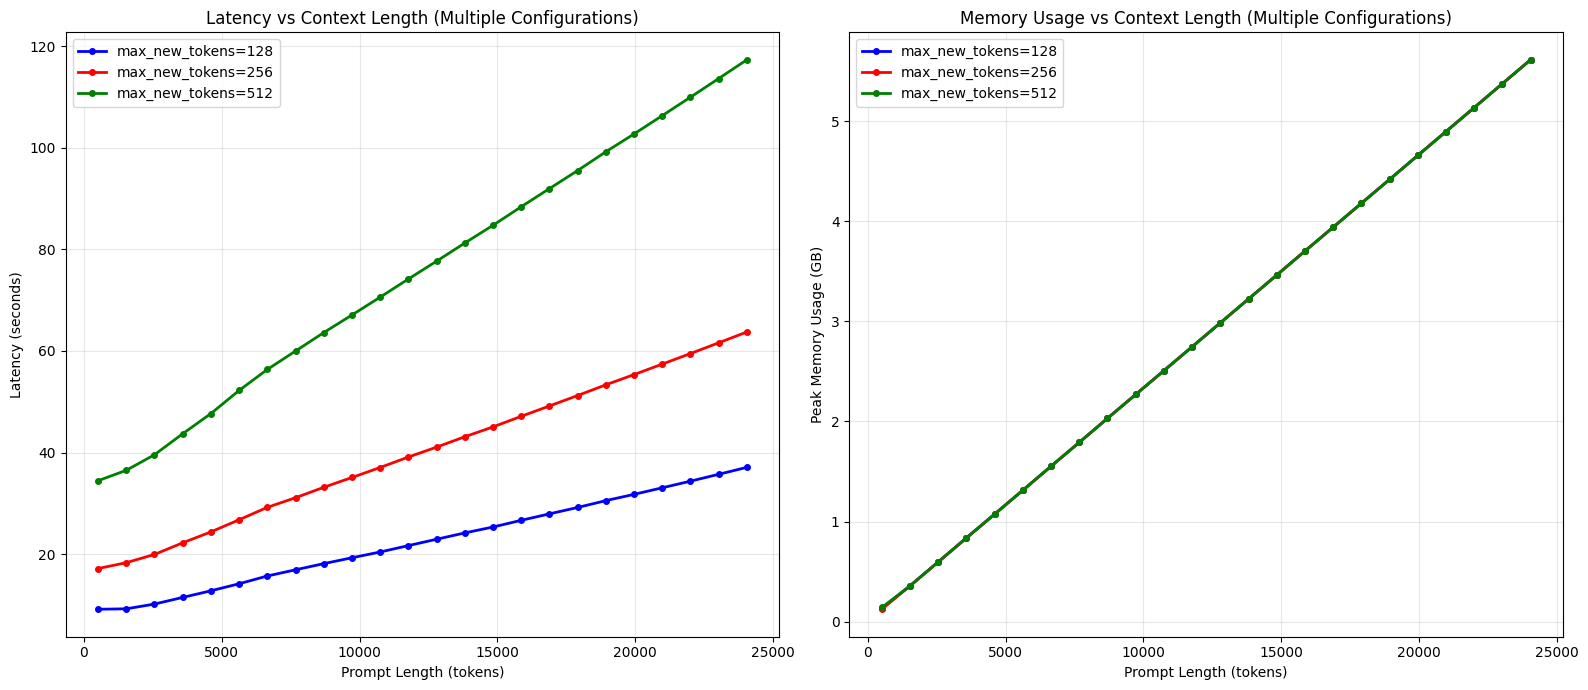


Multi-Configuration Benchmark Summary:

max_new_tokens=128:
  Max promot length: 24,047 tokens
  Max latency: 37.10s, Slope: 0.0012
  Max memory: 5.61GB, Slope: 0.0002

max_new_tokens=256:
  Max promot length: 24,047 tokens
  Max latency: 63.74s, Slope: 0.0020
  Max memory: 5.61GB, Slope: 0.0002

max_new_tokens=512:
  Max promot length: 24,047 tokens
  Max latency: 117.30s, Slope: 0.0035
  Max memory: 5.61GB, Slope: 0.0002



In [ ]:
plot_multi_results(results)

**Analysis, part 1**. From this plot it seems like memory consumption doesn't depend on `max_new_tokens`, only on `prompt_length`. But that's true only when the ratio `prompt_length / max_new_tokens` is large enough. Let's run the same benchmark with smaller prompts and relatively larger completions.

We'll also print the predicted kv-cache size, which is

```
(prompt_length + completion_length) * 131072 bytes
```

In [ ]:
# Run benchmarks for different max_new_tokens values
max_new_tokens_values = [128, 256, 512, 1024, 2048]
results = {}

for max_new_tokens in max_new_tokens_values:
   print(f"\n{'='*50}")
   print(f"Testing max_new_tokens={max_new_tokens}")
   print(f"{'='*50}")

   params = {
       "max_new_tokens": max_new_tokens,
       "temperature": 0.6,
       "top_p": 0.9,
       "do_sample": True,
   }

   prompt_lengths, latencies, memory_allocated, completion_lengths = run_context_length_benchmark(
       start_tokens=128,
       step_tokens=128,
       max_tokens=1088,
       generation_params=params,
       python_files=python_files
   )

   if prompt_lengths:
       results[max_new_tokens] = {
           'prompt_lengths': prompt_lengths,
           'completion_lengths': completion_lengths,
           'latencies': latencies,
           'memory_usage': memory_allocated
       }


Testing max_new_tokens=128
Using generation parameters: {'do_sample': True, 'temperature': 0.6, 'top_p': 0.9, 'max_new_tokens': 128, 'eos_token_id': None}
Using question: What is the purpose and functionality of this code?
Starting benchmark from 128 to 1088 tokens (step: 128)
Prompt: 129 tokens, Completion: 128 tokens, Latency: 8.32s, Memory: 0.04GB
Prompt: 257 tokens, Completion: 128 tokens, Latency: 8.42s, Memory: 0.06GB
Prompt: 385 tokens, Completion: 128 tokens, Latency: 8.53s, Memory: 0.09GB
Prompt: 513 tokens, Completion: 128 tokens, Latency: 8.60s, Memory: 0.13GB
Prompt: 639 tokens, Completion: 128 tokens, Latency: 8.67s, Memory: 0.15GB
Prompt: 767 tokens, Completion: 128 tokens, Latency: 8.77s, Memory: 0.18GB
Prompt: 895 tokens, Completion: 128 tokens, Latency: 8.82s, Memory: 0.21GB
Prompt: 1022 tokens, Completion: 128 tokens, Latency: 8.92s, Memory: 0.24GB

Testing max_new_tokens=256
Using generation parameters: {'do_sample': True, 'temperature': 0.6, 'top_p': 0.9, 'max_new_

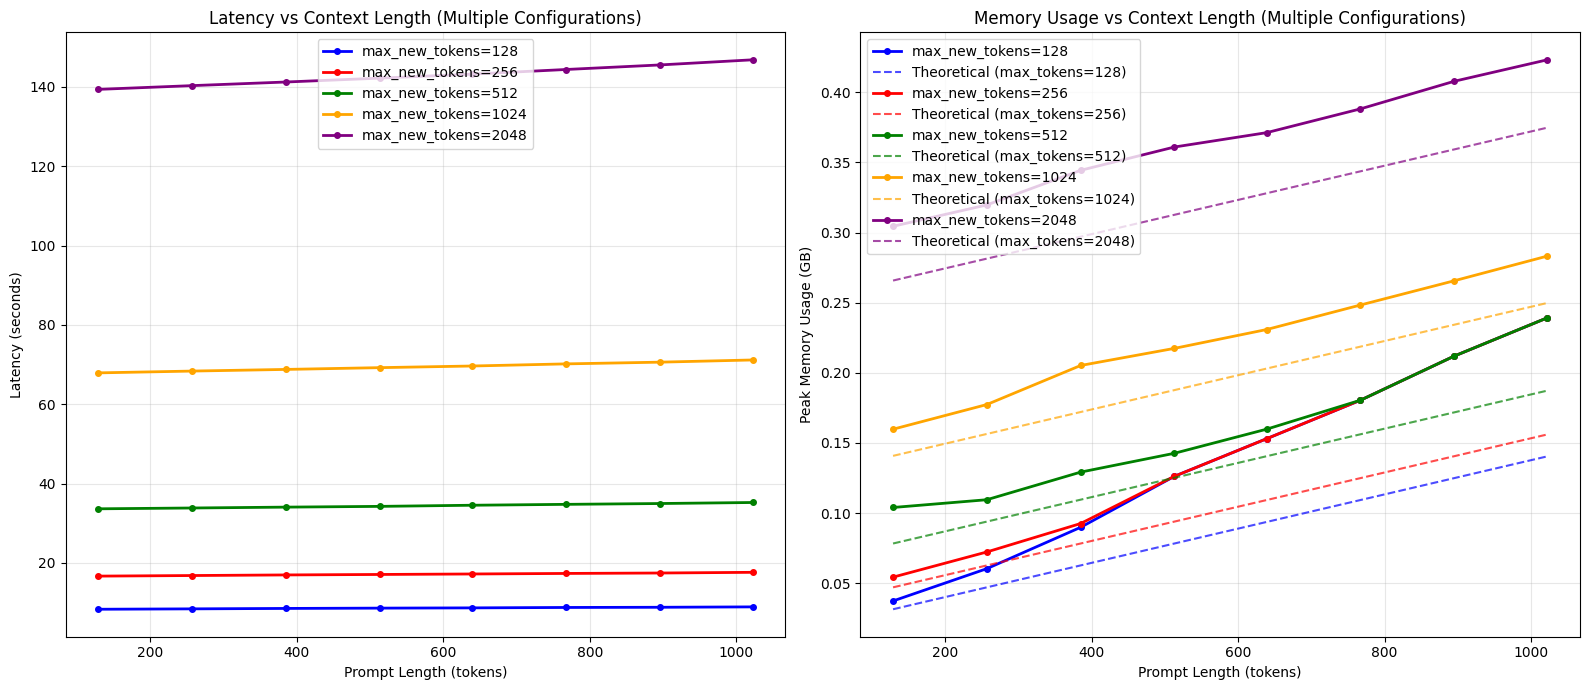


Multi-Configuration Benchmark Summary:

max_new_tokens=128:
  Max prompt length: 1,022 tokens
  Max latency: 8.92s, Slope: 0.0007
  Max memory: 0.24GB, Slope: 0.0002
  Max theoretical memory: 0.14GB

max_new_tokens=256:
  Max prompt length: 1,022 tokens
  Max latency: 17.63s, Slope: 0.0011
  Max memory: 0.24GB, Slope: 0.0002
  Max theoretical memory: 0.16GB

max_new_tokens=512:
  Max prompt length: 1,022 tokens
  Max latency: 35.23s, Slope: 0.0018
  Max memory: 0.24GB, Slope: 0.0002
  Max theoretical memory: 0.19GB

max_new_tokens=1024:
  Max prompt length: 1,022 tokens
  Max latency: 71.15s, Slope: 0.0036
  Max memory: 0.28GB, Slope: 0.0001
  Max theoretical memory: 0.25GB

max_new_tokens=2048:
  Max prompt length: 1,022 tokens
  Max latency: 146.81s, Slope: 0.0083
  Max memory: 0.42GB, Slope: 0.0001
  Max theoretical memory: 0.37GB



In [ ]:
plot_multi_results(results)

**Analysis, part 2**. We can see several interesting features here:

At the beginning, the memory consumption somewhat follows the `seq_len * 131072` pattern, with a small overhead, but as `prompt_length` grows, memory consumption switches to something near `2 * seq_len * 131072`.

Explaining this isn't easy, and it seems to be connected to how memory is allocated on GPU. Theoretically, Pytorch allocates memory for kv-cache of length `(prompt_length + max_new_tokens)` at the start of generation. However, it seems that when it comes to actual memory allocation on GPU, twice as much memory might be allocated, if we surpass the size of a GPU memory slab.

The next plot illustrates a similar pattern for `Qwen/Qwen2.5-7B-Instruct`.

Let's also save the results; we'll need them for the next task.

In [ ]:
import pickle

with open('results_nohook.pkl', 'wb') as f:
  pickle.dump(results, f)

results_old = results

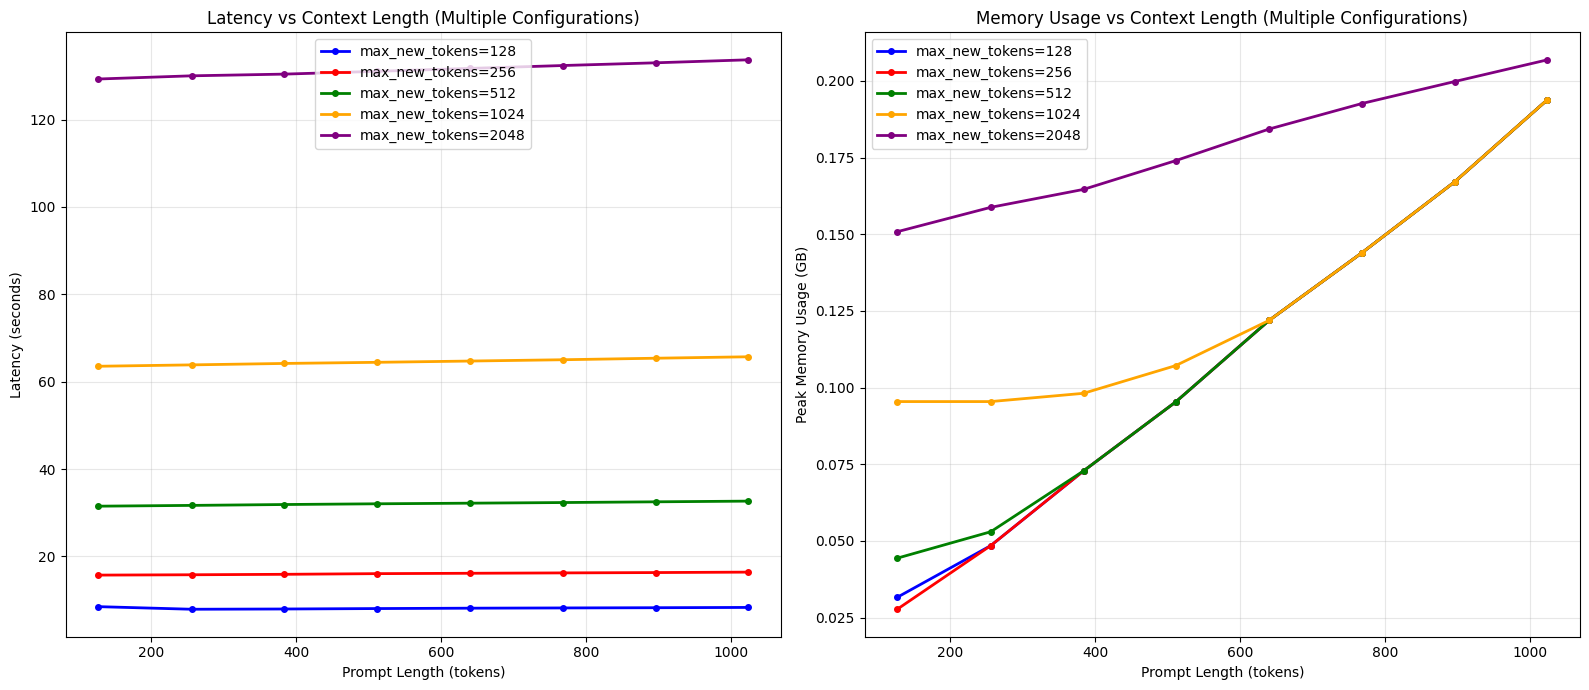


Multi-Configuration Benchmark Summary:

max_new_tokens=128:
  Max promot length: 1,024 tokens
  Max latency: 8.50s, Slope: -0.0002
  Max memory: 0.19GB, Slope: 0.0002

max_new_tokens=256:
  Max promot length: 1,024 tokens
  Max latency: 16.40s, Slope: 0.0008
  Max memory: 0.19GB, Slope: 0.0002

max_new_tokens=512:
  Max promot length: 1,024 tokens
  Max latency: 32.66s, Slope: 0.0013
  Max memory: 0.19GB, Slope: 0.0002

max_new_tokens=1024:
  Max promot length: 1,024 tokens
  Max latency: 65.70s, Slope: 0.0024
  Max memory: 0.19GB, Slope: 0.0001

max_new_tokens=2048:
  Max promot length: 1,024 tokens
  Max latency: 133.67s, Slope: 0.0049
  Max memory: 0.21GB, Slope: 0.0001



In [ ]:
plot_multi_results(results)

## Task 2. Directly measuring the KV-cache size

In Task 1, we relied on quantifying total memory allocation and theoretical KV-cache size. Now, let's see if the actual size of KV-cache matches our theoretical predictions.

For that, you'll need to use Pytorch hooks. However, the transformer may be reluctant to show you the kv-cache, and some additional work might be needed.

**Disclaimer**. The particular code might vary between models and attention implementations, so be extra careful if you try using the advice below. It should work for **Llama-3.1-8B** though.

**Advice**. To get KV-cache, you'll need to allow your hook to receive `kwargs` argument in addition to the usual `module, input, output`. For that, register your hook as follows:

```python
layer.self_attn.register_forward_hook(your_hook, with_kwargs=True)
```

Now, `your hook` will have interface

```python
your_hook(module, input, kwargs, output)
```

and the cache for the `layer_idx`-th layer will be in

```python
cache = kwargs.get("past_key_value")
k, v = cache[layer_idx]
```

Now, you can calculate the size of the key-cache in GB as

```python
k.numel()  * k.element_size() / 2**20
```

The hook will be called every time transformer is inferenced - that is, once during prompt processing and each time a new token is generated. Of course, you need the *maximal* kv-cache size. Though it can be interesting to check if the kv-cache size changes during generation (it shouldn't).

When you finish with the hook, run the benchmark for relatively small `prompt_length` values (like, $\leqslant$ 1024) and relatively large `max_new_tokens` - like from `prompt_length` to `2*prompt_length`. Plot how kv-cache size changes with `prompt_length` or `(prompt_length + completion_length)` and check if it aligns with theoretical estimates.

**Solution**

Let's define the necessary hooks and update the whole benchmarking-related classes.

We'll plot results from Task 1 alongside Task 2 results to check that hooks don't increase memory usage. Such things may happen in some scenarios. For example, if you try to capture attention scores, you might end up with larger memory consumption, if your implementation of attention parallelizes things, avoiding materialization of the whole $QK^T$ matrix in memory.

In [ ]:
class KVCacheMemoryTracker:
    """
    Track KV-cache memory usage during generation with multiple measurement approaches
    """

    def __init__(self, model):
        self.model = model
        self.kv_sizes_per_step = []  # (step, layer, MiB)
        self.max_kv_per_layer = []  # Track max KV size per layer
        self.memory_snapshots = []
        self.hooks = []
        self.layers_with_hooks = []  # Track which layers have hooks for cleanup

    def register_kv_hooks(self):
        """Register forward hooks to monitor KV cache creation per layer"""
        # NOTE: This implementation is specifically designed for Llama-3.1-8B
        # For other models, the output structure might differ

        def make_probe(layer_idx: int):
            def hook_fn(module, args, kwargs, output):
                cache = kwargs.get("past_key_value")
                if cache is None:
                    print("No cache found :O")
                    return

                k, v = cache[layer_idx]
                kv_mb = (k.numel() + v.numel()) * k.element_size() / 2**20

                step = getattr(module, "_step", 0)
                self.kv_sizes_per_step.append((step, layer_idx, kv_mb))

                module._step = step + 1

            return hook_fn

        # Register hooks for each attention layer
        for i, layer in enumerate(self.model.model.layers):
            layer._step = 0  # Initialize step counter
            hook = layer.self_attn.register_forward_hook(make_probe(i), with_kwargs=True)
            self.hooks.append(hook)
            self.layers_with_hooks.append(layer.self_attn)

    def remove_hooks(self):
        """Clean up registered hooks - handles both normal and failed hooks"""
        try:
            # Try normal removal first
            for hook in self.hooks:
                hook.remove()
        except Exception:
            pass  # Some hooks might have failed

        # Force clear all hooks from layers we touched
        for layer in self.layers_with_hooks:
            try:
                layer._forward_hooks.clear()
            except Exception:
                pass

        # Clean up our tracking
        self.hooks.clear()
        self.layers_with_hooks.clear()

    def measure_kv_from_past_key_values(self, past_key_values):
        """Calculate total KV cache size from past_key_values - fallback method"""
        if past_key_values is None:
            return 0.0

        total_bytes = sum(
            t.numel() * t.element_size()
            for layer in past_key_values
            for t in layer  # k and v tensors
        )
        return total_bytes / (2**20)  # Convert to MiB

    def take_memory_snapshot(self, step_name=""):
        """Take a memory snapshot for detailed analysis"""
        torch.cuda.empty_cache()
        allocated = torch.cuda.memory_allocated() / (2**30)  # GB
        reserved = torch.cuda.memory_reserved() / (2**30)   # GB

        snapshot = {
            'step': step_name,
            'allocated_gb': allocated,
            'reserved_gb': reserved,
            'timestamp': time.time()
        }
        self.memory_snapshots.append(snapshot)
        return snapshot

    def get_memory_diff(self, baseline_allocated):
        """Get memory difference from baseline"""
        current = torch.cuda.memory_allocated()
        return (current - baseline_allocated) / (2**20)  # MiB

    def get_max_kv_cache_size(self):
        """Get the maximum KV cache size per layer (not sum across all calls)"""
        if not self.kv_sizes_per_step:
            return 0.0, []

        # Group by layer and find max for each layer
        layer_max = {}
        for step, layer_idx, kv_mb in self.kv_sizes_per_step:
            if layer_idx not in layer_max:
                layer_max[layer_idx] = 0.0
            layer_max[layer_idx] = max(layer_max[layer_idx], kv_mb)

        # Return total max and per-layer breakdown
        total_max_kv = sum(layer_max.values())
        per_layer_max = [layer_max.get(i, 0.0) for i in range(len(self.model.model.layers))]

        return total_max_kv, per_layer_max

    def reset_tracking(self):
        """Reset all tracking data"""
        self.kv_sizes_per_step.clear()
        self.max_kv_per_layer.clear()
        self.memory_snapshots.clear()

    def get_summary(self):
        """Get a summary of tracked KV cache data"""
        max_kv_total, per_layer_max = self.get_max_kv_cache_size()

        summary = {
            'total_kv_steps_recorded': len(self.kv_sizes_per_step),
            'max_total_kv_cache_mb': max_kv_total,
            'max_kv_per_layer_mb': per_layer_max,
            'num_layers_tracked': len(self.model.model.layers),
            'memory_snapshots': len(self.memory_snapshots)
        }
        return summary

In [ ]:
# Default generation parameters (can be overridden in benchmark function)
DEFAULT_GENERATION_PARAMS = {
    "do_sample": True,
    "temperature": 0.6,
    "top_p": 0.9,
    "max_new_tokens": 128,
    "eos_token_id": None,
}


def measure_generation_with_kv_tracking(prompt, context_length, generation_params, model, tokenizer, kv_tracker):
    """Enhanced generation measurement with detailed KV-cache tracking"""

    # Reset tracker for this measurement
    kv_tracker.reset_tracking()

    # Clear cache and reset memory stats
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    baseline_allocated = torch.cuda.memory_allocated()

    # Take initial memory snapshot
    kv_tracker.take_memory_snapshot("initial")

    try:
        # Register KV tracking hooks
        kv_tracker.register_kv_hooks()

        # Tokenize input
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=context_length)
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        # Record start time
        start_time = time.time()

        # Generate with KV cache tracking
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                return_dict_in_generate=True,
                output_scores=False,
                use_cache=True,
                **generation_params
            )

        end_time = time.time()
        latency = end_time - start_time

        # Get KV cache size from our tracking (preferred method)
        max_kv_total, per_layer_max = kv_tracker.get_max_kv_cache_size()

        # Fallback: measure from past_key_values if tracking failed
        if max_kv_total == 0.0:
            max_kv_total = kv_tracker.measure_kv_from_past_key_values(outputs.past_key_values)

        # Take final memory snapshot
        kv_tracker.take_memory_snapshot("final")

        # Calculate memory metrics
        peak_allocated = torch.cuda.max_memory_allocated()
        total_memory_used = (peak_allocated - baseline_allocated) / (1024**3)  # GB

        # Get generated text
        generated_ids = outputs.sequences[0][inputs['input_ids'].shape[1]:]
        completion_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
        completion_tokens = len(generated_ids)

        # Calculate tokens per second
        tokens_per_second = completion_tokens / latency if latency > 0 else 0

        # Prepare results
        results = {
            'latency': latency,
            'total_memory_gb': total_memory_used,
            'kv_cache_mb': max_kv_total,
            'completion_tokens': completion_tokens,
            'tokens_per_second': tokens_per_second,
            'completion_text': completion_text,
            'kv_tracker_summary': kv_tracker.get_summary(),
            'error': None
        }

        return results

    except Exception as e:
        return {
            'latency': None,
            'total_memory_gb': None,
            'kv_cache_mb': None,
            'completion_tokens': None,
            'tokens_per_second': None,
            'completion_text': None,
            'kv_tracker_summary': None,
            'error': str(e)
        }

    finally:
        # Always clean up hooks - critical for preventing stuck hooks
        try:
            kv_tracker.remove_hooks()
        except Exception as cleanup_error:
            print(f"Warning: Hook cleanup failed: {cleanup_error}")

In [ ]:
def run_kv_aware_context_benchmark(
    model,
    tokenizer,
    python_files,
    start_tokens=512,
    step_tokens=128,
    max_tokens=125000,
    generation_params=None,
    question="What is the purpose and functionality of this code?"
):
    """
    Enhanced benchmark that tracks KV-cache usage alongside traditional metrics
    """

    # Use default generation params if none provided
    if generation_params is None:
        generation_params = DEFAULT_GENERATION_PARAMS.copy()
    else:
        merged_params = DEFAULT_GENERATION_PARAMS.copy()
        merged_params.update(generation_params)
        generation_params = merged_params

    print(f"Starting KV-Cache Aware Benchmark")
    print(f"Token range: {start_tokens} → {max_tokens} (step: {step_tokens})")

    # Initialize KV tracker
    kv_tracker = KVCacheMemoryTracker(model)

    # Storage for results
    results = {
        'prompt_lengths': [],
        'latencies': [],
        'total_memory_gb': [],
        'kv_cache_mb': [],
        'completion_lengths': [],
        'tokens_per_second': [],
        'generation_params': generation_params
    }

    current_tokens = start_tokens

    while current_tokens <= max_tokens:
        print(f"Testing {current_tokens} tokens...")

        try:
            # Create prompt of target length
            prompt = create_context_of_length(python_files, current_tokens, question)
            actual_tokens = len(tokenizer.encode(prompt, add_special_tokens=True))

            # Run enhanced measurement
            result = measure_generation_with_kv_tracking(
                prompt, current_tokens, generation_params, model, tokenizer, kv_tracker
            )

            if result['error']:
                print(f"Error at {current_tokens} tokens: {result['error']}")
                break

            # Store results
            results['prompt_lengths'].append(actual_tokens)
            results['latencies'].append(result['latency'])
            results['total_memory_gb'].append(result['total_memory_gb'])
            results['kv_cache_mb'].append(result['kv_cache_mb'])
            results['completion_lengths'].append(result['completion_tokens'])
            results['tokens_per_second'].append(result['tokens_per_second'])

            # Simple one-line progress report (as requested)
            print(f"Prompt: {actual_tokens}, Completion: {result['completion_tokens']}, Latency: {result['latency']:.2f}s, Memory: {result['total_memory_gb']:.2f}GB, KV-Cache: {result['kv_cache_mb']:.1f}MB")

        except Exception as e:
            print(f"Failed at {current_tokens} tokens: {e}")
            break

        current_tokens += step_tokens

    print(f"\nBenchmark completed! Tested {len(results['prompt_lengths'])} configurations.")
    return results


In [ ]:
def plot_multi_kv_results(results_dict, results_old=None):
    """
    Plot multiple KV-aware benchmark results for comparison with optional old results
    Args:
        results_dict (dict): New KV-aware results
        results_old (dict): Optional old results from previous experiments
    """
    if not results_dict:
        print("No results to plot")
        return

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 20))

    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    # === LATENCY PLOT ===
    config_index = 0

    # Plot new results (KV-aware) - solid lines
    for config_name, results in sorted(results_dict.items()):
        color = colors[config_index % len(colors)]
        label = f"New: {config_name}"

        ax1.plot(results['prompt_lengths'], results['latencies'], 'o-',
                color=color, label=label, markersize=4, linewidth=2)
        config_index += 1

    # Plot old results if provided - triangular markers with thicker lines
    if results_old:
        for config_name, results in sorted(results_old.items()):
            color = colors[config_index % len(colors)]
            label = f"Old: max_tokens={config_name}"

            ax1.plot(results['prompt_lengths'], results['latencies'], '^--',
                    color=color, label=label, markersize=6, linewidth=3, alpha=0.7)
            config_index += 1

    ax1.set_title('Latency Comparison: New KV-Cache vs Old Results', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Prompt Length (tokens)', fontsize=12)
    ax1.set_ylabel('Latency (seconds)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # === MEMORY PLOT ===
    config_index = 0

    # Plot new results
    for config_name, results in sorted(results_dict.items()):
        color = colors[config_index % len(colors)]
        prompt_lengths = results['prompt_lengths']

        # Extract max_tokens from config_name (assuming format like "max_tokens=X")
        try:
            max_new_tokens = int(config_name)
        except:
            max_new_tokens = 1024  # fallback value

        # New total memory - solid line with circles
        total_memory_gb = results['total_memory_gb']
        ax2.plot(prompt_lengths, total_memory_gb, 'o-',
                color=color, label=f"New Memory: {config_name}",
                markersize=4, linewidth=2)

        # New KV cache - dotted line with smaller markers
        kv_cache_gb = [mb / 1024 for mb in results['kv_cache_mb']]  # Convert MB to GB
        ax2.plot(prompt_lengths, kv_cache_gb, ':s',
                color=color, label=f"New KV Cache: {config_name}",
                markersize=3, linewidth=2, alpha=0.8)

        # Theoretical memory - dashed line
        theoretical_memory_gb = [(131072 * (prompt_len + max_new_tokens)) / (1024**3)
                               for prompt_len in prompt_lengths]
        ax2.plot(prompt_lengths, theoretical_memory_gb, 'x--',
                color=color, label=f"Theoretical: {config_name}",
                linewidth=1.5, alpha=0.6)

        config_index += 1

    # Plot old results if provided - distinctive triangular markers with thick dashed lines
    if results_old:
        for config_name, results in sorted(results_old.items()):
            color = colors[config_index % len(colors)]

            # Old memory - thick dashed line with triangular markers
            ax2.plot(results['prompt_lengths'], results['memory_usage'], '^--',
                    color=color, label=f"Old Memory: max_tokens={config_name}",
                    markersize=6, linewidth=3, alpha=0.7, markerfacecolor='none',
                    markeredgewidth=2)
            config_index += 1

    ax2.set_title('Memory Usage Comparison: Multiple Metrics', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Prompt Length (tokens)', fontsize=12)
    ax2.set_ylabel('Memory Usage (GB)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


    print(f"\n{'='*80}")
    print(f"Legend:")
    print(f"  • Solid lines (○): New total memory usage")
    print(f"  • Dotted lines (□): New KV cache usage")
    print(f"  • Dashed lines: Theoretical memory (131072 × tokens)")
    print(f"  • Thick dashed with triangles (△): Old memory results")
    print(f"{'='*80}")


In [ ]:
tokenizer, model, pipeline = create_pipeline(model_name="meta-llama/Meta-Llama-3.1-8B-Instruct")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Run benchmarks for different max_new_tokens values
max_new_tokens_values = [128, 256, 512, 1024, 2048]
results = {}

for max_new_tokens in max_new_tokens_values:
    print(f"\n{'='*50}")
    print(f"Testing max_new_tokens={max_new_tokens}")
    print(f"{'='*50}")

    params = {
        "max_new_tokens": max_new_tokens,
        "temperature": 0.6,
        "top_p": 0.9,
        "do_sample": True,
    }

    # Use the new KV-aware benchmark function
    benchmark_results = run_kv_aware_context_benchmark(
        model=model,
        tokenizer=tokenizer,
        python_files=python_files,
        start_tokens=128,
        step_tokens=128,
        max_tokens=1088,
        generation_params=params,
        question="What is the purpose and functionality of this code?"
    )

    if benchmark_results['prompt_lengths']:
        # Store results in the format expected by plotting functions
        results[max_new_tokens] = {
            'prompt_lengths': benchmark_results['prompt_lengths'],
            'latencies': benchmark_results['latencies'],
            'total_memory_gb': benchmark_results['total_memory_gb'],
            'kv_cache_mb': benchmark_results['kv_cache_mb'],
            'completion_lengths': benchmark_results['completion_lengths'],
            'tokens_per_second': benchmark_results['tokens_per_second'],
            'generation_params': benchmark_results['generation_params']
        }



Testing max_new_tokens=128
Starting KV-Cache Aware Benchmark
Token range: 128 → 1088 (step: 128)
Testing 128 tokens...
Prompt: 129, Completion: 128, Latency: 8.32s, Memory: 0.04GB, KV-Cache: 31.9MB
Testing 256 tokens...
Prompt: 257, Completion: 128, Latency: 8.39s, Memory: 0.06GB, KV-Cache: 47.9MB
Testing 384 tokens...
Prompt: 385, Completion: 128, Latency: 8.50s, Memory: 0.09GB, KV-Cache: 63.9MB
Testing 512 tokens...
Prompt: 513, Completion: 128, Latency: 8.59s, Memory: 0.12GB, KV-Cache: 79.9MB
Testing 640 tokens...
Prompt: 639, Completion: 128, Latency: 8.66s, Memory: 0.15GB, KV-Cache: 95.8MB
Testing 768 tokens...
Prompt: 767, Completion: 128, Latency: 8.76s, Memory: 0.18GB, KV-Cache: 111.8MB
Testing 896 tokens...
Prompt: 895, Completion: 128, Latency: 8.81s, Memory: 0.21GB, KV-Cache: 127.8MB
Testing 1024 tokens...
Prompt: 1022, Completion: 128, Latency: 8.90s, Memory: 0.24GB, KV-Cache: 143.6MB

Benchmark completed! Tested 8 configurations.

Testing max_new_tokens=256
Starting KV-Ca

Let's save the results.

In [ ]:
with open('kv_aware_results.pkl', 'wb') as f:
  pickle.dump(results, f)

And now, the plot!

You can see that the kv-cache size is actually very well aligned with theoretical predictions. However, memory allocation of GPU is a completely different story...

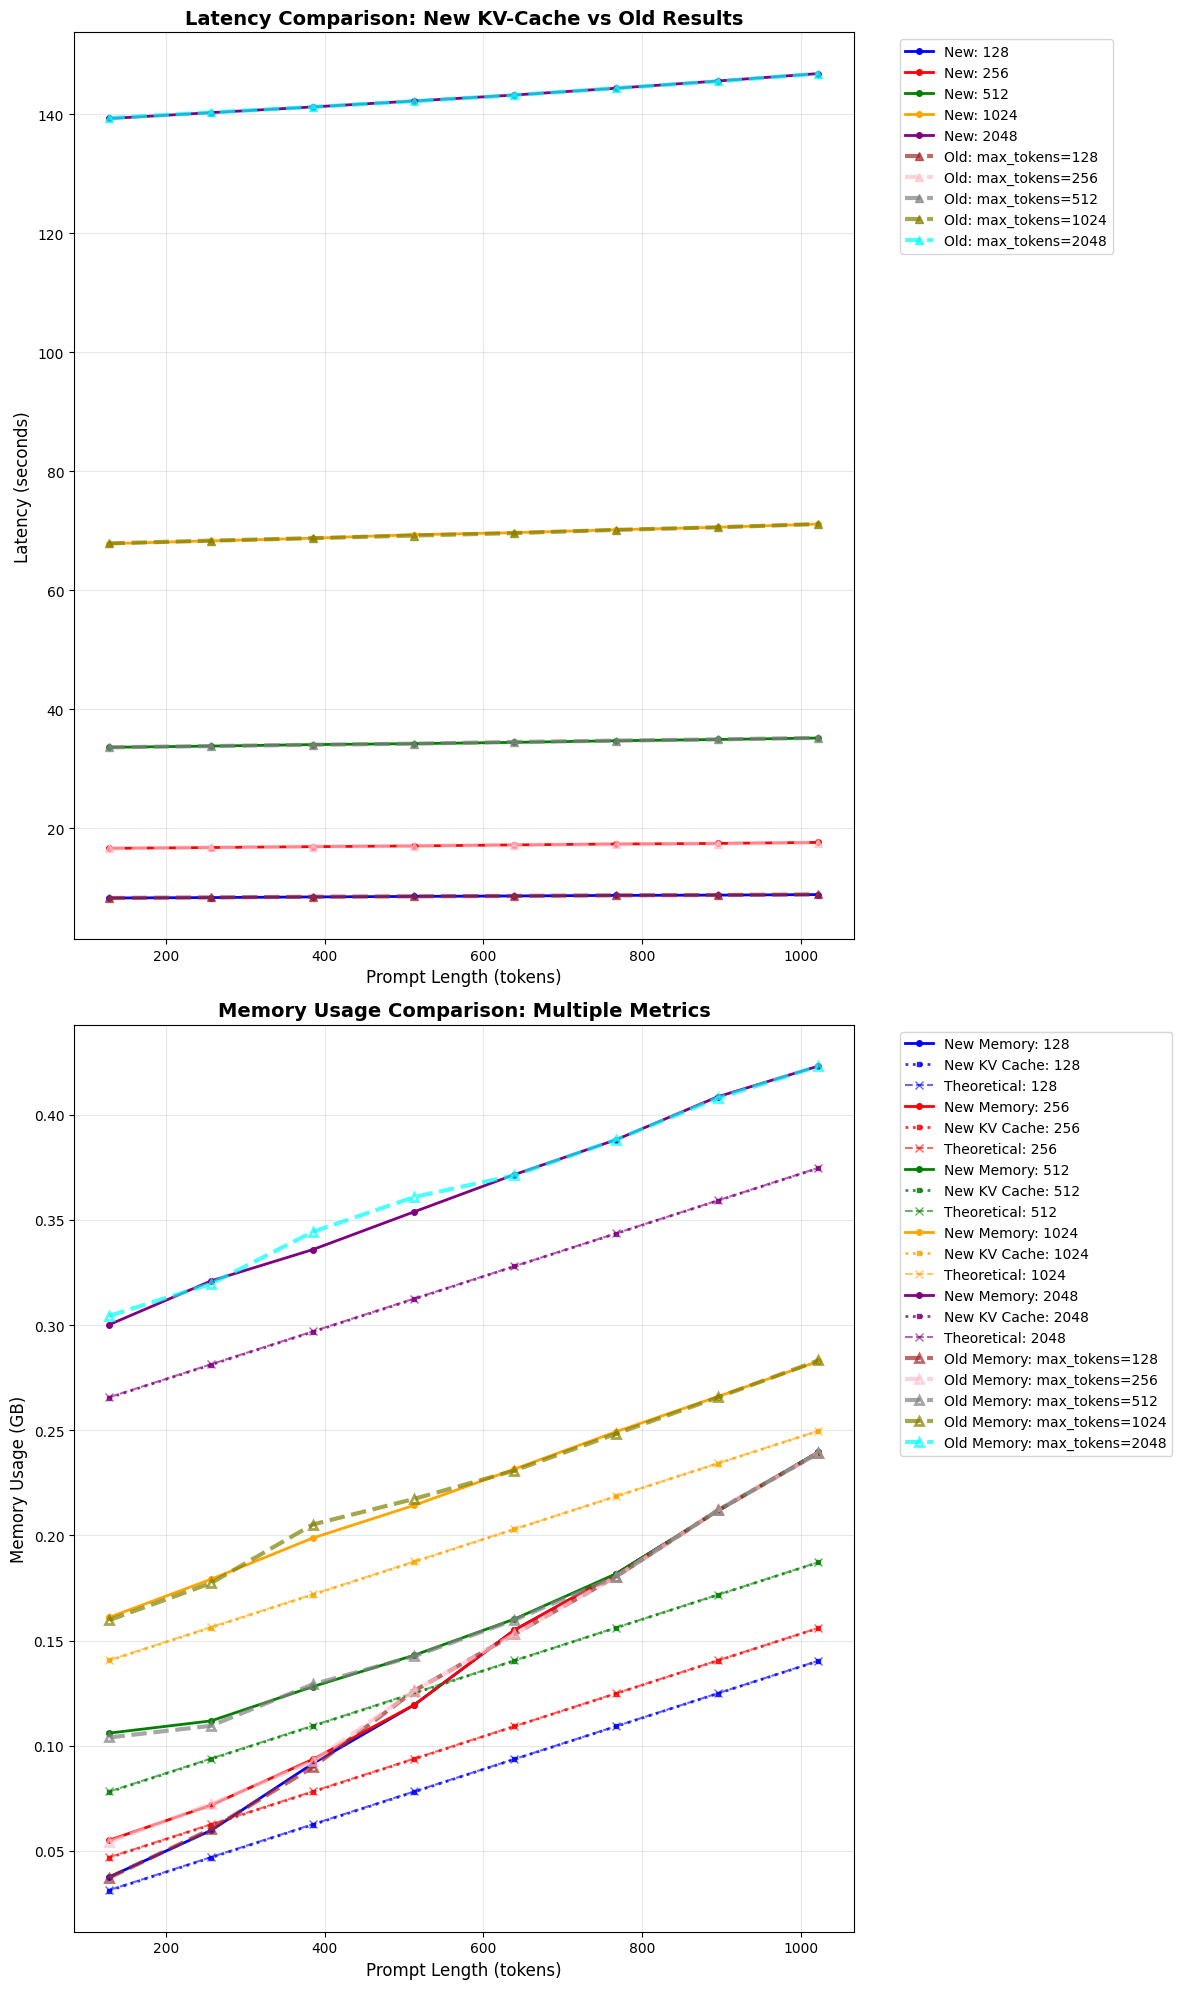


Legend:
  • Solid lines (○): New total memory usage
  • Dotted lines (□): New KV cache usage
  • Dashed lines: Theoretical memory (131072 × tokens)
  • Thick dashed with triangles (△): Old memory results


In [ ]:
plot_multi_kv_results(results, results_old)

## Task 3. FlashAttention2

In this task, you'll try using **FlashAttention2**, the all-so-fashionable implementation of attention, which is so cool that it's better to use it whenever you can.

The problem is though that it's capricious and tricky to make work. It only supports certain GPU families (A100, H100, and H200 are among them; L4 and L40s are not). Also, it requires quite specific combinations of libraries. Your best chance at it is using a good docker image.

Below, we describe how we managed to run it in colab on June 30, 2025. However, we can give you no guarantee that the same code will work on your local machine or in another cloud.

In [ ]:
!pip install torch=='2.4.1+cu121' torchvision=='0.19.1+cu121' torchaudio=='2.4.1+cu121' --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 799.0/799.0 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 121.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 98.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 101.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 128.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/19

In [ ]:
!pip install -v flash-attn==2.8.0.post2 --no-build-isolation

Using pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 65.8 MB/s eta 0:00:00
  Running command python setup.py egg_info
  /usr/local/lib/python3.11/dist-packages/setuptools/__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!

          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          ********************************************************************************

  !!
    dist.fetch_build_eggs(dist.setup_requires)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 8.1 MB/s eta 0:00:00


  torch.__version__  = 2.4.1+cu121


  running egg_info
  creating /tmp/pip-pip-egg-info-mfk5gyqs/flash_attn.egg-info
  writing /tmp/pip-pip-egg-info-mfk5gyqs/flash_attn.egg-info/PKG-IN

In [ ]:
!pip install transformers==4.51.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 95.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4


If the next cell runs successfully, you've nailed it!
Otherwise, you're in trouble...

In [ ]:
import flash_attn

Now, this should load a model with FlashAttention2. Just check the output; it should show whether you were successful.

In [ ]:
import os
os.environ["TRANSFORMERS_NO_TP"] = "1"
import time
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers
from huggingface_hub import snapshot_download
from pathlib import Path

# Read HF token
with open("hf_access_token", "r") as file:
    hf_access_token = file.read().strip()

from huggingface_hub import login
login(token=hf_access_token)

def create_pipeline(
    model_name: str = "meta-llama/Meta-Llama-3.1-8B-Instruct",
    cache_dir: str = "/inference_essentials/model/",
    use_flash_attention: bool = True):

    # Load the tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        use_fast=False
    )

    # Downloading the model
    print(f"Downloading model {model_name}...")
    snapshot_download(
        repo_id=model_name,
        cache_dir=cache_dir,
        max_workers=15
    )

    # Prepare model loading arguments
    model_kwargs = {
        "torch_dtype": torch.bfloat16,
        "device_map": "auto",
        "cache_dir": cache_dir,
        "local_files_only": True,
        "token": hf_access_token,
    }

    # Add FlashAttention2 configuration if available
    if use_flash_attention:
        print("Loading model with FlashAttention2...")
        model_kwargs["attn_implementation"] = "flash_attention_2"
        # Some models may need this additional parameter, but generally it is deprecated
        # model_kwargs["use_flash_attention_2"] = True
    else:
        print("Loading model with standard attention...")

    # Load the model
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        **model_kwargs
    )


    # Create pipeline with appropriate configuration
    pipeline_kwargs = {
        "task": "text-generation",
        "model": model,
        "tokenizer": tokenizer,
        "model_kwargs": {
            "torch_dtype": torch.bfloat16,
            "cache_dir": cache_dir,
        },
        "device_map": "auto",
        "token": hf_access_token,
    }

    pipeline = transformers.pipeline(**pipeline_kwargs)

    # Configure tokenizer settings
    pipeline.tokenizer.pad_token_id = pipeline.tokenizer.eos_token_id
    pipeline.model.generation_config.pad_token_id = pipeline.tokenizer.pad_token_id
    pipeline.tokenizer.padding_side = 'left'

    # Check if FlashAttention2 is actually being used
    if hasattr(model.config, 'attn_implementation'):
        print(f"Attention implementation: {model.config.attn_implementation}")
    elif hasattr(model.config, '_attn_implementation'):
        print(f"Attention implementation: {model.config._attn_implementation}")

    return tokenizer, model, pipeline

In [ ]:
tokenizer, model, pipeline = create_pipeline(model_name="Qwen/Qwen2.5-7B-Instruct",
                                             use_flash_attention=True)

**Solution**. We'll just reuse the same code. End-to-end latency is indeed lower than with the default attention implementation. The memory consumption patterns stay more or less the same.

In [ ]:
# Run benchmarks for different max_new_tokens values
max_new_tokens_values = [128, 256, 512, 1024, 2048]
results = {}

for max_new_tokens in max_new_tokens_values:
   print(f"\n{'='*50}")
   print(f"Testing max_new_tokens={max_new_tokens}")
   print(f"{'='*50}")

   params = {
       "max_new_tokens": max_new_tokens,
       "temperature": 0.6,
       "top_p": 0.9,
       "do_sample": True,
   }

   prompt_lengths, latencies, memory_allocated, completion_lengths = run_context_length_benchmark(
       start_tokens=128,
       step_tokens=128,
       max_tokens=1088,
       generation_params=params,
       python_files=python_files
   )

   if prompt_lengths:
       results[max_new_tokens] = {
           'prompt_lengths': prompt_lengths,
           'completion_lengths': completion_lengths,
           'latencies': latencies,
           'memory_usage': memory_allocated
       }


Testing max_new_tokens=128
Using generation parameters: {'do_sample': True, 'temperature': 0.6, 'top_p': 0.9, 'max_new_tokens': 128, 'eos_token_id': None}
Using question: What is the purpose and functionality of this code?
Starting benchmark from 128 to 1088 tokens (step: 128)
Prompt: 127 tokens, Completion: 128 tokens, Latency: 6.76s, Memory: 0.03GB
Prompt: 256 tokens, Completion: 128 tokens, Latency: 5.17s, Memory: 0.05GB
Prompt: 384 tokens, Completion: 128 tokens, Latency: 5.12s, Memory: 0.07GB
Prompt: 511 tokens, Completion: 128 tokens, Latency: 5.10s, Memory: 0.10GB
Prompt: 640 tokens, Completion: 128 tokens, Latency: 5.14s, Memory: 0.12GB
Prompt: 768 tokens, Completion: 128 tokens, Latency: 5.20s, Memory: 0.14GB
Prompt: 896 tokens, Completion: 128 tokens, Latency: 5.07s, Memory: 0.17GB
Prompt: 1024 tokens, Completion: 128 tokens, Latency: 5.13s, Memory: 0.19GB

Testing max_new_tokens=256
Using generation parameters: {'do_sample': True, 'temperature': 0.6, 'top_p': 0.9, 'max_new_

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Prompt: 256 tokens, Completion: 256 tokens, Latency: 10.08s, Memory: 0.05GB
Prompt: 384 tokens, Completion: 256 tokens, Latency: 10.18s, Memory: 0.07GB
Prompt: 511 tokens, Completion: 256 tokens, Latency: 10.12s, Memory: 0.10GB
Prompt: 640 tokens, Completion: 256 tokens, Latency: 10.15s, Memory: 0.12GB
Prompt: 768 tokens, Completion: 256 tokens, Latency: 10.16s, Memory: 0.14GB
Prompt: 896 tokens, Completion: 256 tokens, Latency: 10.17s, Memory: 0.17GB
Prompt: 1024 tokens, Completion: 256 tokens, Latency: 10.06s, Memory: 0.19GB

Testing max_new_tokens=512
Using generation parameters: {'do_sample': True, 'temperature': 0.6, 'top_p': 0.9, 'max_new_tokens': 512, 'eos_token_id': None}
Using question: What is the purpose and functionality of this code?
Starting benchmark from 128 to 1088 tokens (step: 128)
Prompt: 127 tokens, Completion: 512 tokens, Latency: 20.00s, Memory: 0.04GB
Prompt: 256 tokens, Completion: 512 tokens, Latency: 20.20s, Memory: 0.05GB
Prompt: 384 tokens, Completion: 512 

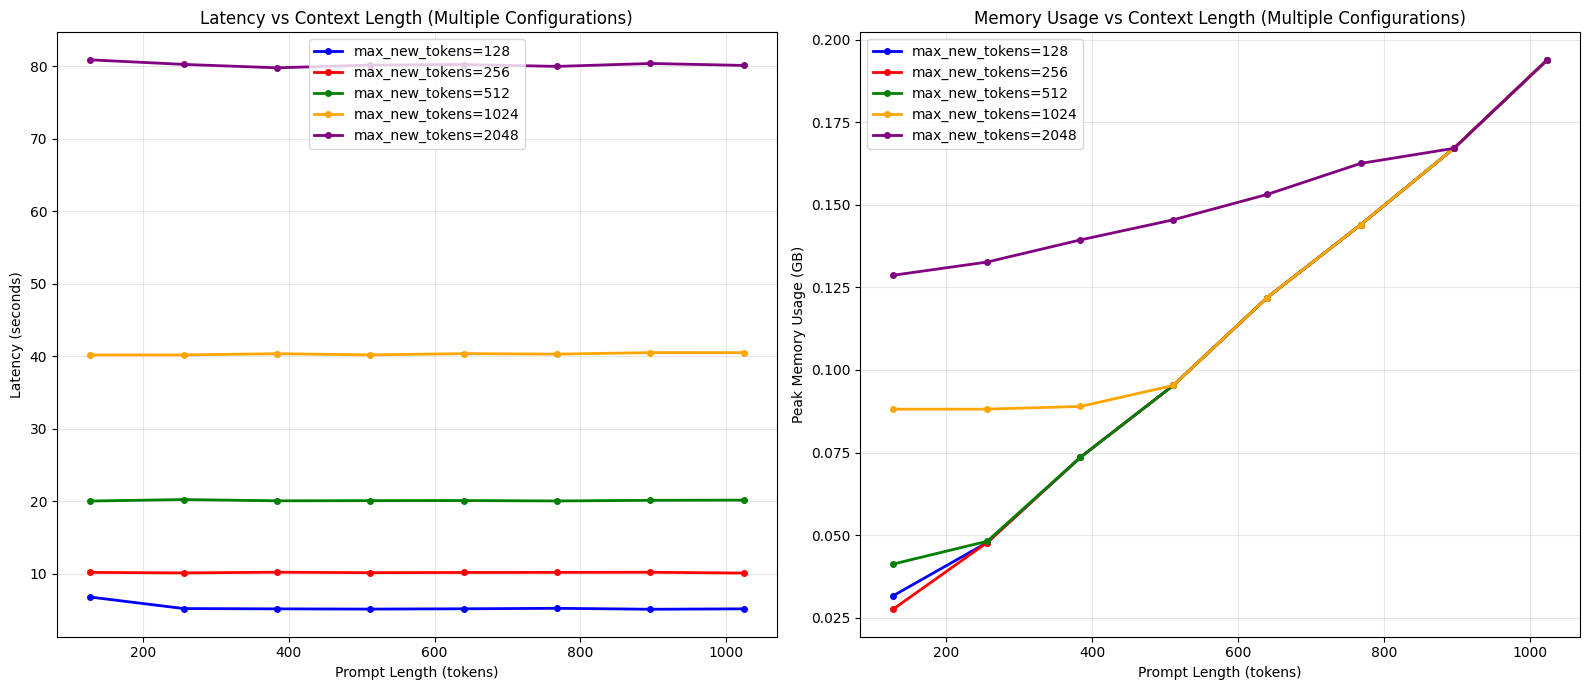


Multi-Configuration Benchmark Summary:

max_new_tokens=128:
  Max promot length: 1,024 tokens
  Max latency: 6.76s, Slope: -0.0018
  Max memory: 0.19GB, Slope: 0.0002

max_new_tokens=256:
  Max promot length: 1,024 tokens
  Max latency: 10.18s, Slope: -0.0001
  Max memory: 0.19GB, Slope: 0.0002

max_new_tokens=512:
  Max promot length: 1,024 tokens
  Max latency: 20.20s, Slope: 0.0001
  Max memory: 0.19GB, Slope: 0.0002

max_new_tokens=1024:
  Max promot length: 1,024 tokens
  Max latency: 40.47s, Slope: 0.0004
  Max memory: 0.19GB, Slope: 0.0001

max_new_tokens=2048:
  Max promot length: 1,024 tokens
  Max latency: 80.86s, Slope: -0.0009
  Max memory: 0.19GB, Slope: 0.0001



In [ ]:
plot_multi_results(results)